# Emotion detection for facial expressions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import torch
import pandas as pd

from models import CNN,CNNBcos
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader, random_split
from torchvision import transforms

import torch.optim as optim
import numpy as np

from utils import grad_to_img, explanation_mode, to_numpy_img
#from modules.bcosconv2d import BcosConv2d

import seaborn as sns

In [2]:
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Loading the dataset

In [3]:
df = pd.read_csv('fer2013.csv')

class FER2013Dataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        #Load pixels and labels from csv
        pixels = self.dataframe.iloc[idx, 1]
        label = int(self.dataframe.iloc[idx, 0])

        # Convert to 48x48 pixel image
        image = np.fromstring(pixels, sep=' ').reshape(48, 48).astype(np.uint8)

        if self.transform:
            image = self.transform(image)

        return image, label

# Define transformation
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Create dataset
fer_dataset = FER2013Dataset(dataframe=df, transform=transform)

# Split in Training (80%), Validation (20%)
train_size = int(0.8 * len(fer_dataset))
val_size = len(fer_dataset) - train_size 
torch.manual_seed(123)
train_dataset, val_dataset = random_split(fer_dataset, [train_size, val_size])

# Create dataloader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)



## Define the training and validation

In [4]:
def train(model, train_loader, val_loader, epochs, optimizer, scheduler):
    model.train()
    val_accuracies=[]
    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
      
            outputs = model(images)
            #print(outputs.shape)
            #print(labels.shape)
            loss = cosine_loss(outputs, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            running_loss += loss.item()
        val_loss, val_accuracy = validate(model, val_loader)
        scheduler.step(val_loss)
        val_accuracies.append(val_accuracy)
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")
    return val_accuracies

# Cosine similarity-based loss function
def cosine_loss(outputs, labels):
    labels_one_hot = F.one_hot(labels, num_classes=outputs.size(1)).float()
    cosine_sim = F.cosine_similarity(outputs, labels_one_hot, dim=1)
    loss = 1 - torch.mean(cosine_sim)  # Use cosine similarity as loss
    return loss

# Validation function with cosine accuracy
def validate(model, val_loader):
    model.eval()
    val_loss = 0.0
    cosine_acc = 0.0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)

            loss =cosine_loss(outputs, labels)
            val_loss += loss.item()
            cosine_acc += cosine_accuracy(outputs, labels)
            total += labels.size(0)
    return val_loss / len(val_loader), cosine_acc / len(val_loader)

# Cosine accuracy calculation
def cosine_accuracy(outputs, labels):
    labels_one_hot = F.one_hot(labels, num_classes=outputs.size(1)).float()
    cosine_sim = F.cosine_similarity(outputs, labels_one_hot, dim=1)
    correct = torch.sum(cosine_sim > 0.5).item()
    total = labels.size(0)
    accuracy = correct / total
    return accuracy

## Train and evaluate the CNN and the Bcos version of CNN

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training on device {device}.")
n_epochs=10

Training on device cpu.


In [6]:
# Example usage with CNN
model = CNN().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, nesterov=True, momentum=0.9, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.75, patience=5, verbose=True)
val_normal=train(model, train_loader, val_loader, n_epochs, optimizer, scheduler)

c:\Users\arnel\pyver\py3123\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/10], Loss: 0.5099, Validation Loss: 0.4670, Validation Accuracy: 0.5435
Epoch [2/10], Loss: 0.4495, Validation Loss: 0.4404, Validation Accuracy: 0.5699
Epoch [3/10], Loss: 0.4265, Validation Loss: 0.4315, Validation Accuracy: 0.5892
Epoch [4/10], Loss: 0.4127, Validation Loss: 0.4236, Validation Accuracy: 0.6087
Epoch [5/10], Loss: 0.4022, Validation Loss: 0.4155, Validation Accuracy: 0.6108
Epoch [6/10], Loss: 0.3925, Validation Loss: 0.4157, Validation Accuracy: 0.6120
Epoch [7/10], Loss: 0.3858, Validation Loss: 0.4226, Validation Accuracy: 0.6011
Epoch [8/10], Loss: 0.3795, Validation Loss: 0.4150, Validation Accuracy: 0.6156
Epoch [9/10], Loss: 0.3748, Validation Loss: 0.4091, Validation Accuracy: 0.6245
Epoch [10/10], Loss: 0.3702, Validation Loss: 0.4079, Validation Accuracy: 0.6313


In [7]:


# Example usage with CNNBcos
modelbcos = CNNBcos().to(device)
optimizer = optim.SGD(modelbcos.parameters(), lr=0.01, nesterov=True, momentum=0.9, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.75, patience=5, verbose=True)
val_bcos=train(modelbcos, train_loader, val_loader, n_epochs, optimizer, scheduler)

Epoch [1/10], Loss: 0.5194, Validation Loss: 0.4545, Validation Accuracy: 0.5271
Epoch [2/10], Loss: 0.4378, Validation Loss: 0.4354, Validation Accuracy: 0.5624
Epoch [3/10], Loss: 0.4069, Validation Loss: 0.4132, Validation Accuracy: 0.5792
Epoch [4/10], Loss: 0.3872, Validation Loss: 0.4105, Validation Accuracy: 0.6024
Epoch [5/10], Loss: 0.3720, Validation Loss: 0.4115, Validation Accuracy: 0.5914
Epoch [6/10], Loss: 0.3599, Validation Loss: 0.4001, Validation Accuracy: 0.5999
Epoch [7/10], Loss: 0.3479, Validation Loss: 0.3971, Validation Accuracy: 0.6109
Epoch [8/10], Loss: 0.3386, Validation Loss: 0.4160, Validation Accuracy: 0.5724
Epoch [9/10], Loss: 0.3277, Validation Loss: 0.4071, Validation Accuracy: 0.5959
Epoch [10/10], Loss: 0.3178, Validation Loss: 0.4111, Validation Accuracy: 0.5877


In [8]:
emotion_dic={0:"Angry", 1:"Disgust", 2:"Fear", 3:"Happy", 4:"Sad", 5:"Surprise", 6:"Neutral"}

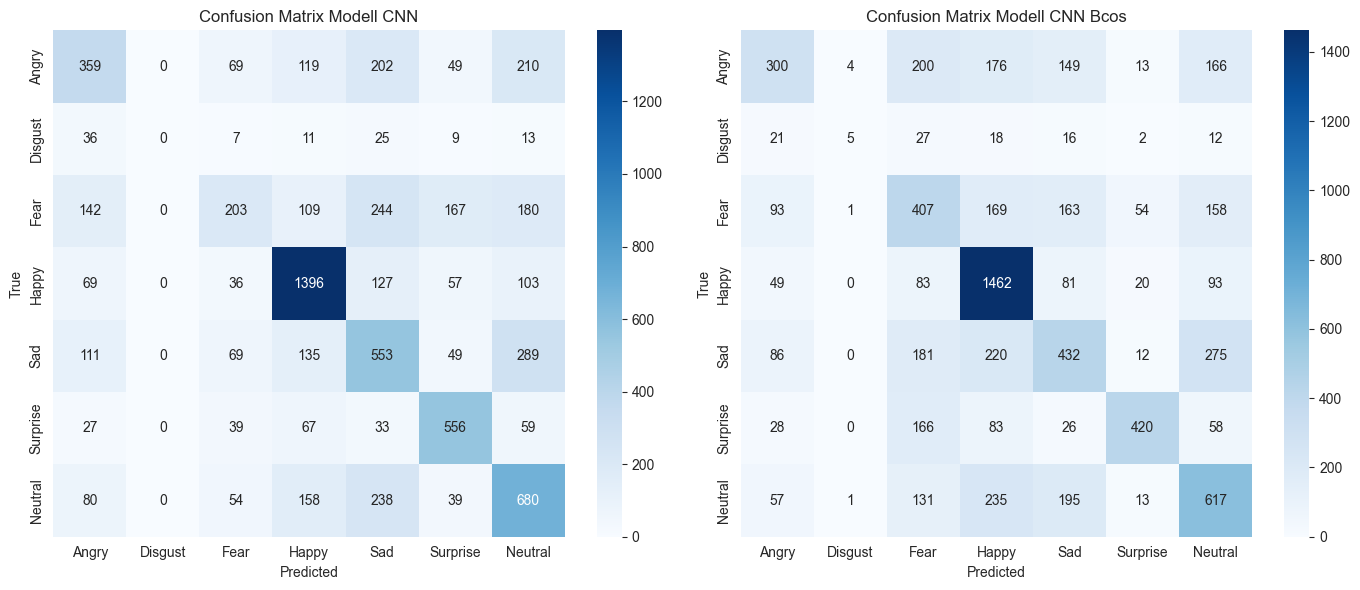

In [9]:
# Funktion zur Berechnung der Confusion Matrix
def get_confusion_matrix(model, val_loader, num_classes):
    model.eval()
    confusion_matrix = torch.zeros(num_classes, num_classes)
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            for t, p in zip(labels.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

    return confusion_matrix

# Beispiel: Nutzung der Confusion Matrix mit zwei Modellen und einem Validation DataLoader
conf_matrix1 = get_confusion_matrix(model, val_loader, num_classes=7)  # Confusion Matrix für Modell 1
conf_matrix2 = get_confusion_matrix(modelbcos, val_loader, num_classes=7)  # Confusion Matrix für Modell 2

# Erstelle die Subplots nebeneinander (1 Reihe, 2 Spalten)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Erstelle eine Liste der Klassennamen basierend auf den Indizes
labels = [emotion_dic[i] for i in range(len(emotion_dic))]

# Plot der Confusion Matrix für Modell 1
sns.heatmap(conf_matrix1, annot=True, fmt="g", cmap="Blues", xticklabels=labels, yticklabels=labels, ax=axes[0])
axes[0].set_title('Confusion Matrix Modell CNN')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('True')

# Plot der Confusion Matrix für Modell 2
sns.heatmap(conf_matrix2, annot=True, fmt="g", cmap="Blues", xticklabels=labels, yticklabels=labels, ax=axes[1])
axes[1].set_title('Confusion Matrix Modell CNN Bcos')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('True')

# Layout anpassen und anzeigen
plt.tight_layout()
plt.show()

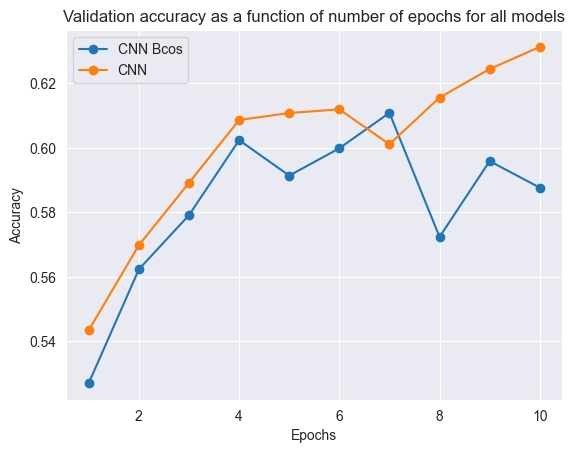

<Figure size 640x480 with 0 Axes>

In [10]:
plt.plot(range(1, len(val_bcos) + 1), val_bcos, marker='o', label="CNN Bcos")
plt.plot(range(1, len(val_normal) + 1), val_normal, marker='o', label="CNN")
# Achsen und Titel
plt.title('Validation accuracy as a function of number of epochs for all models')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot anzeigen
plt.show()
plt.savefig("accuracy.png")

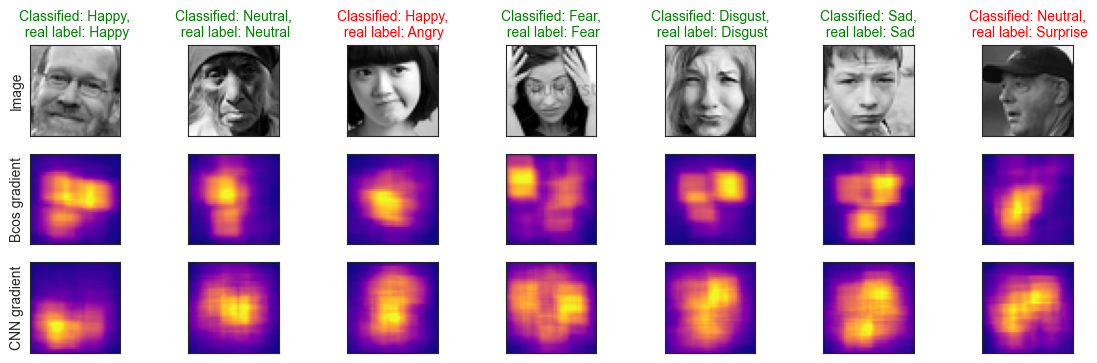

In [12]:
imgs = [0,3,10,20,30,50,60]
fig, (img_axes, wbcos_axes,w_axes) = plt.subplots(3, len(imgs), figsize=(len(imgs)*2, 4))


sns.set_style("white")
for ax in img_axes:
    ax.set_xticks([])
    ax.set_yticks([])

for ax in w_axes:
    ax.set_xticks([])
    ax.set_yticks([])
for ax in wbcos_axes:
    ax.set_xticks([])
    ax.set_yticks([])

    explanation_mode(modelbcos, True)
for ax_idx, img_idx in enumerate(imgs):
    modelbcos.zero_grad()
    img = train_loader.dataset[img_idx][0][None]   
    label=train_loader.dataset[img_idx][1]
    img.requires_grad=True
    #For bcos network
    topbcos, c_idxbcos = modelbcos(img)[0].topk(1)
    img.grad = None
    topbcos[0].backward(retain_graph=True)
    wbcos = img.grad
    #for normal cnn
    top, c_idx = model(img)[0].topk(1)
    img.grad = None
    top[0].backward(retain_graph=True)
    w = img.grad
    
    img_axes[ax_idx].imshow(to_numpy_img(img[0]),cmap='gray')
    img_axes[0].set_ylabel("Image")
    if(label==c_idxbcos.item()):
        img_axes[ax_idx].set_title(f"Classified: {emotion_dic[c_idxbcos.item()].split(',')[0]},\n real label: {emotion_dic[label].split(',')[0]}", fontsize=10,color="green")
    else:
        img_axes[ax_idx].set_title(f"Classified: {emotion_dic[c_idxbcos.item()].split(',')[0]},\n real label: {emotion_dic[label].split(',')[0]}", fontsize=10,color="red")
    wbcos_axes[ax_idx].imshow(grad_to_img(img[0], wbcos[0]),cmap='plasma')
    wbcos_axes[0].set_ylabel("Bcos gradient")
    w_axes[ax_idx].imshow(grad_to_img(img[0], w[0]),cmap='plasma')
    w_axes[0].set_ylabel("CNN gradient")
fig.savefig("example_figure.png")